# **Cryptocurrency Liquidity Predictor | Vikash Kumar | wiryvikash15@gmail.com**

In [1]:

!pip install kaggle

from google.colab import files

print("Please upload your kaggle.json file:")
files.upload()

# Move the kaggle.json file to the required directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API configured.")

Please upload your kaggle.json file:


Saving coin_Bitcoin.csv to coin_Bitcoin.csv
Saving coin_Cardano.csv to coin_Cardano.csv
Saving coin_ChainLink.csv to coin_ChainLink.csv
Saving coin_Cosmos.csv to coin_Cosmos.csv
Saving coin_CryptocomCoin.csv to coin_CryptocomCoin.csv
Saving coin_Dogecoin.csv to coin_Dogecoin.csv
Saving coin_EOS.csv to coin_EOS.csv
Saving coin_Ethereum.csv to coin_Ethereum.csv
Saving coin_Iota.csv to coin_Iota.csv
Saving coin_Litecoin.csv to coin_Litecoin.csv
Saving coin_Monero.csv to coin_Monero.csv
Saving coin_NEM.csv to coin_NEM.csv
Saving coin_Polkadot.csv to coin_Polkadot.csv
Saving coin_Solana.csv to coin_Solana.csv
Saving coin_Stellar.csv to coin_Stellar.csv
Saving coin_Tether.csv to coin_Tether.csv
Saving coin_Tron.csv to coin_Tron.csv
Saving coin_Uniswap.csv to coin_Uniswap.csv
Saving coin_USDCoin.csv to coin_USDCoin.csv
Saving coin_WrappedBitcoin.csv to coin_WrappedBitcoin.csv
Saving coin_XRP.csv to coin_XRP.csv
Saving coin_Aave.csv to coin_Aave.csv
Saving coin_BinanceCoin.csv to coin_BinanceC

In [2]:
import pandas as pd
import numpy as np
import glob # To find all CSV files

data_folder_path = '/content/coin_*.csv'
csv_files = glob.glob(data_folder_path)
print(f"Found {len(csv_files)} coin CSV files.")

df_list = []
for file in csv_files:
    try:
        df_temp = pd.read_csv(file, parse_dates=['Date'])
        df_temp = df_temp[
            (df_temp['Date'].dt.year == 2016) | (df_temp['Date'].dt.year == 2017)
        ]
        if not {'Symbol', 'Date', 'Close', 'Volume'}.issubset(df_temp.columns):
            print(f"Skipping {file}: missing required columns.")
            continue
        df_list.append(df_temp)
    except Exception as e:
        print(f"Error loading {file}: {e}")

df = pd.concat(df_list, ignore_index=True)
df = df.sort_values(by=['Symbol', 'Date']).reset_index(drop=True)
print("\nData loaded successfully:")
print(f"DataFrame shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

# ---  Data Preprocessing ---
print(f"\nMissing values before cleaning:\n{df.isnull().sum()}")
df['Volume'] = df.groupby('Symbol')['Volume'].transform(lambda x: x.ffill().bfill())
df['Close'] = df.groupby('Symbol')['Close'].transform(lambda x: x.ffill().bfill())
df.dropna(subset=['Close', 'Volume'], inplace=True)

original_rows = len(df)
df = df[df['Close'] > 0].copy()
print(f"Removed {original_rows - len(df)} rows with 0 Close price.")

print(f"\nMissing values after cleaning:\n{df.isnull().sum()}")

# --- Feature Engineering ---
def create_features(group):
    group['daily_return'] = group['Close'].pct_change()

    # Add a larger epsilon just in case Volume is 0
    group['illiquidity'] = group['daily_return'].abs() / (group['Volume'] + 1e-6)

    group['volatility_30d'] = group['daily_return'].rolling(window=30).std()
    group['moving_avg_close_30d'] = group['Close'].rolling(window=30).mean()
    group['moving_avg_volume_30d'] = group['Volume'].rolling(window=30).mean()

    group['illiquidity_lag_1'] = group['illiquidity'].shift(1)
    group['volume_lag_1'] = group['Volume'].shift(1)
    group['volatility_lag_1'] = group['volatility_30d'].shift(1)

    return group

print("\nStarting feature engineering...")
df_features = df.groupby('Symbol').apply(create_features)

df_features.replace([np.inf, -np.inf], np.nan, inplace=True)

#  Drop all rows that have ANY NaN values (from rolling/shifts OR inf fix)
df_features = df_features.dropna()
# -------------------------

print("Feature engineering complete and inf/-inf values removed.")

print("\nChecking for NaN/inf in final features...")
features_list = [
    'volatility_30d', 'moving_avg_close_30d', 'moving_avg_volume_30d',
    'illiquidity_lag_1', 'volume_lag_1', 'volatility_lag_1'
]
check_df = df_features[features_list]
print(f"Has NaN: {check_df.isnull().values.any()}")
print(f"Has Inf: {np.isinf(check_df).values.any()}")
# -------------------

Found 23 coin CSV files.

Data loaded successfully:
DataFrame shape: (7424, 10)
Date range: 2016-01-01 23:59:59 to 2017-12-31 23:59:59

Missing values before cleaning:
SNo          0
Name         0
Symbol       0
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Marketcap    0
dtype: int64
Removed 0 rows with 0 Close price.

Missing values after cleaning:
SNo          0
Name         0
Symbol       0
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Marketcap    0
dtype: int64

Starting feature engineering...
Feature engineering complete and inf/-inf values removed.

Checking for NaN/inf in final features...
Has NaN: False
Has Inf: False


/tmp/ipython-input-3148471994.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_features = df.groupby('Symbol').apply(create_features)


Starting Exploratory Data Analysis...


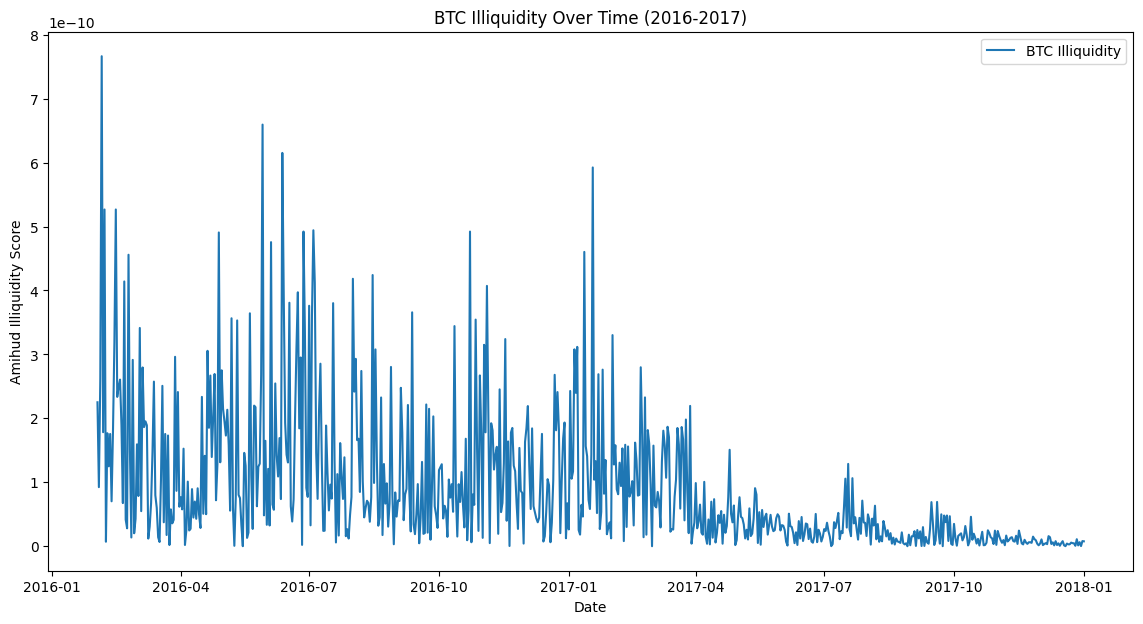

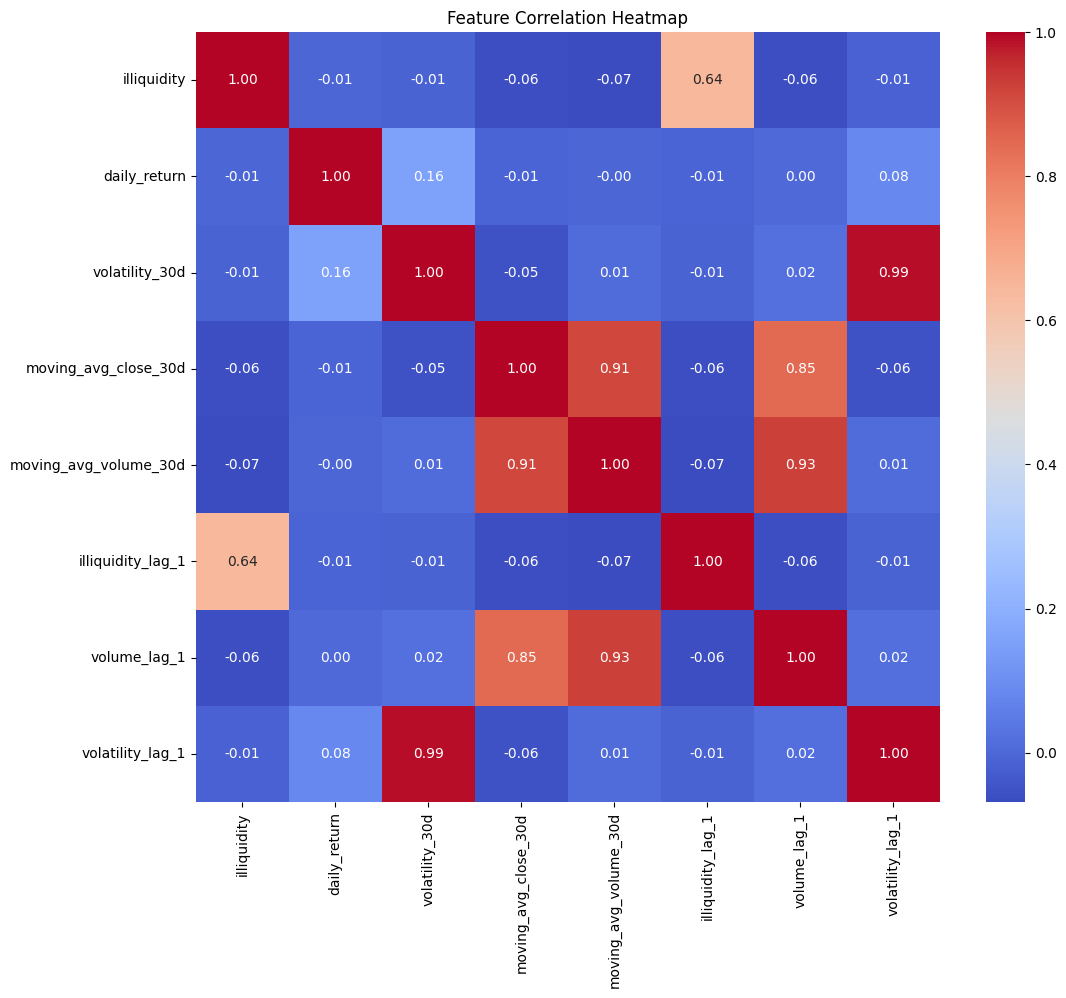

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Starting Exploratory Data Analysis...")

# Plot illiquidity for Bitcoin
plt.figure(figsize=(14, 7))
# Filter for Bitcoin (BTC) and plot
btc_data = df_features[df_features['Symbol'] == 'BTC']
plt.plot(btc_data['Date'], btc_data['illiquidity'], label='BTC Illiquidity')
plt.title('BTC Illiquidity Over Time (2016-2017)')
plt.ylabel('Amihud Illiquidity Score')
plt.xlabel('Date')
plt.legend()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 10))
corr_features = [
    'illiquidity',
    'daily_return',
    'volatility_30d',
    'moving_avg_close_30d',
    'moving_avg_volume_30d',
    'illiquidity_lag_1',
    'volume_lag_1',
    'volatility_lag_1'
]
sns.heatmap(
    df_features[corr_features].corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.2f'
)
plt.title('Feature Correlation Heatmap')
plt.show()

In [4]:
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

print("--- Starting Data Processing ---")

# ---  Data Collection ---
data_folder_path = '/content/coin_*.csv'
csv_files = glob.glob(data_folder_path)
print(f"Found {len(csv_files)} coin CSV files.")
df_list = []
for file in csv_files:
    try:
        df_temp = pd.read_csv(file, parse_dates=['Date'])
        df_temp = df_temp[
            (df_temp['Date'].dt.year == 2016) | (df_temp['Date'].dt.year == 2017)
        ]
        if not {'Symbol', 'Date', 'Close', 'Volume'}.issubset(df_temp.columns):
            continue
        df_list.append(df_temp)
    except Exception as e:
        print(f"Error loading {file}: {e}")
df = pd.concat(df_list, ignore_index=True)
df = df.sort_values(by=['Symbol', 'Date']).reset_index(drop=True)
df.dropna(subset=['Close', 'Volume'], inplace=True)
df = df[df['Close'] > 0].copy()
df = df[df['Volume'] >= 0].copy()
print("Data loaded and pre-cleaned.")

# ---  Feature Engineering ---
def create_features_robust(group):
    group['daily_return'] = group['Close'].pct_change()
    group['illiquidity'] = group['daily_return'].abs() / (group['Volume'] + 1e-6)
    group['volatility_30d'] = group['daily_return'].rolling(window=30).std()
    group['moving_avg_close_30d'] = group['Close'].rolling(window=30).mean()
    group['moving_avg_volume_30d'] = group['Volume'].rolling(window=30).mean()
    group.replace([np.inf, -np.inf], np.nan, inplace=True)
    group['illiquidity_lag_1'] = group['illiquidity'].shift(1)
    group['volume_lag_1'] = group['Volume'].shift(1)
    group['volatility_lag_1'] = group['volatility_30d'].shift(1)
    return group
print("\nStarting feature engineering...")
df_features = df.groupby('Symbol').apply(create_features_robust)
df_features.replace([np.inf, -np.inf], np.nan, inplace=True)
df_features = df_features.dropna()
print("Feature engineering complete.")

# --- Clip "TOO LARGE" values ---
print("\nRemoving extreme outliers...")
max_allowed = df_features['illiquidity'].quantile(0.999)
print(f"Clipping all values at 99.9th percentile: {max_allowed}")
df_features['illiquidity'] = df_features['illiquidity'].clip(upper=max_allowed)
df_features['illiquidity_lag_1'] = df_features['illiquidity_lag_1'].clip(upper=max_allowed)
print(f"New max illiquidity: {df_features['illiquidity'].max()}")

print("\n--- Train Model ---")

target = 'illiquidity'
features = [
    'volatility_30d',
    'moving_avg_close_30d',
    'moving_avg_volume_30d',
    'illiquidity_lag_1',
    'volume_lag_1',
    'volatility_lag_1'
]
X = df_features[features]
y = df_features[target]

print("\nRunning pre-scaling checks...")
has_error = False
zero_var_cols = X.columns[X.std() == 0].tolist()
if not zero_var_cols:
    print("✅ Pre-scaling check passed. All features have variance.")

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    split_index = int(len(X_scaled) * 0.8)
    X_train = X_scaled[:split_index]
    X_test = X_scaled[split_index:]
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]

    print(f"Train set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")

    print("\nTraining RandomForestRegressor...")
    model = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        max_depth=10
    )

    try:
        model.fit(X_train, y_train)
        print("✅ Model training complete.")

        print("\nEvaluating model...")
        y_pred = model.predict(X_test)

        # Calculate MSE first, then take the square root for RMSE
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"\n--- Model Performance (on Test Set) ---")
        print(f"RMSE (Root Mean Squared Error): {rmse:.10f}")
        print(f"MAE (Mean Absolute Error):     {mae:.10f}")
        print(f"R² Score:                    {r2:.4f}")

        joblib.dump(model, 'liquidity_model.pkl')
        joblib.dump(scaler, 'scaler.pkl')
        print("\nModel ('liquidity_model.pkl') and scaler ('scaler.pkl') saved successfully.")
        print("Now download the files.")

    except ValueError as e:
        print(f"🔴 TRAINING FAILED. Final error: {e}")
else:
    print(f"🔴 ERROR: Found features with ZERO variance: {zero_var_cols}")
    print("\nTraining Canceled. Please fix data by removing zero-variance features.")

--- Starting Data Processing ---
Found 23 coin CSV files.
Data loaded and pre-cleaned.

Starting feature engineering...
Feature engineering complete.

Removing extreme outliers...
Clipping all values at 99.9th percentile: 3.1593950601622213e-06
New max illiquidity: 3.1593950601622213e-06

--- Train Model ---

Running pre-scaling checks...
✅ Pre-scaling check passed. All features have variance.
Train set size: 5567
Test set size: 1392

Training RandomForestRegressor...


/tmp/ipython-input-2562945098.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_features = df.groupby('Symbol').apply(create_features_robust)


✅ Model training complete.

Evaluating model...

--- Model Performance (on Test Set) ---
RMSE (Root Mean Squared Error): 0.0000000660
MAE (Mean Absolute Error):     0.0000000256
R² Score:                    0.4539

Model ('liquidity_model.pkl') and scaler ('scaler.pkl') saved successfully.
Now download the files.


In [5]:
from google.colab import files

print("Downloading model and scaler files...")
files.download('liquidity_model.pkl')
files.download('scaler.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>